# XGBoost

In [1]:
import xgboost
from xgboost import plot_importance
from bgpredict.helpers import S3Connection
from dotenv import load_dotenv
import multiprocessing
import json
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
from skopt import BayesSearchCV, dump, load
from skopt.plots import plot_objective, plot_histogram
import matplotlib.pyplot as plt 

In [2]:
os.chdir('../')
load_dotenv()
os.chdir('./Baseline')

In [ ]:
start = datetime.now()
location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
engine = create_engine(location)
conn = engine.connect()
raw_df = pd.read_sql("select * from public.tb_final_dataset", conn)
print(f'Load finished in {datetime.now()-start}')
start= datetime.now()
clean_df = clean_data(raw_df)
print(f"Data cleaned in {datetime.now()-start}")

In [71]:
def create_cv_splits(df):
    df = df.reset_index()
    subjects = np.unique(df['subjectid'])
    print(len(subjects), "in subset" )
    cv_splits = []
    for subject in subjects:
        train_idx = np.array(df.loc[(df['subjectid']==subject) & (df['train_set']==1)].index)
        val_idx = np.array(df.loc[(df['subjectid']==subject) & (df['validation_set']==1)].index)
        print(f"train_shape: {train_idx.shape}, val shape: {val_idx.shape}")
        if len(train_idx) < 5 or len(val_idx) < 5:
            print(f"Not enough rows for subject {subject}")
            continue 
        split = (train_idx, val_idx)
        cv_splits.append(split)
    return cv_splits

In [72]:
def train_test_cv_split(df):
    clean_df_reset = df.reset_index()
    
    train_X = clean_df_reset.loc[(clean_df_reset['train_set'] == 1) | (clean_df_reset['validation_set'] == 1) , clean_df_reset.columns != 'bg']
    train_y = clean_df_reset.loc[(clean_df_reset['train_set'] == 1) | (clean_df_reset['validation_set'] == 1), clean_df_reset.columns == 'bg']
    
    test_X = clean_df_reset.loc[(clean_df_reset['test_set'] == 1), clean_df_reset.columns != 'bg']
    test_y = clean_df_reset.loc[(clean_df_reset['test_set'] == 1), clean_df_reset.columns == 'bg']
    
    cv_splits = create_cv_splits(train_X)

    drop_cols = ['train_set', 'validation_set', 'test_set', 'subjectid', 'entryid', 'timestamp_clean']
    train_X = train_X.drop(labels=drop_cols, axis=1)
    test_X = test_X.drop(labels=drop_cols, axis=1)
    
    return train_X, train_y,test_X, test_y, cv_splits

In [86]:
train_X, train_y, test_X, test_y, cv_splits = train_test_cv_split(clean_df)

139 in subset
train_shape: (14334,), val shape: (1599,)
train_shape: (35159,), val shape: (11958,)
train_shape: (31792,), val shape: (16120,)
train_shape: (43606,), val shape: (18730,)
train_shape: (24818,), val shape: (14658,)
train_shape: (16242,), val shape: (5017,)
train_shape: (15877,), val shape: (6460,)
train_shape: (9545,), val shape: (3775,)
train_shape: (8063,), val shape: (3249,)
train_shape: (440,), val shape: (253,)
train_shape: (33824,), val shape: (12195,)
train_shape: (30347,), val shape: (13403,)
train_shape: (3588,), val shape: (19899,)
train_shape: (141057,), val shape: (29285,)
train_shape: (18565,), val shape: (9318,)
train_shape: (38029,), val shape: (25790,)
train_shape: (19410,), val shape: (14884,)
train_shape: (40053,), val shape: (11770,)
train_shape: (19965,), val shape: (12634,)
train_shape: (15003,), val shape: (11190,)
train_shape: (41128,), val shape: (26548,)
train_shape: (108817,), val shape: (28369,)
train_shape: (5509,), val shape: (12595,)
train_sha

In [60]:
# clean_df_reset = clean_df[:100000].reset_index()
# print(clean_df_reset.shape)
# clean_df_reset.index
# train_X = clean_df_reset.loc[(clean_df_reset['train_set'] == 1) | (clean_df_reset['validation_set'] == 1) , clean_df_reset.columns != 'bg']
# train_y = clean_df_reset.loc[(clean_df_reset['train_set'] == 1) | (clean_df_reset['validation_set'] == 1), clean_df_reset.columns == 'bg']
# print(f'train_X: {train_X.shape}, train_y; {train_y.shape}')
# test_X = clean_df_reset.loc[(clean_df_reset['test_set'] == 1), clean_df_reset.columns != 'bg']
# test_y = clean_df_reset.loc[(clean_df_reset['test_set'] == 1), clean_df_reset.columns == 'bg']
# print(f'test_X: {test_X.shape}, train_y; {test_y.shape}')



(100000, 178)
train_X: (98148, 177), train_y; (98148, 1)
test_X: (1852, 177), train_y; (1852, 1)


In [87]:
n_cpu = os.cpu_count()
print(f"Using {n_cpu} CPUs for {len(train_X)} rows")

param = {'max_depth': 2,
      "learning_rate": [0.1,0.2,0.3], #
      "gamma" : 1, # 0 to inf; minimum loss reduction required to make a partition. Larger is more conservative
      "min_child_weight": 3, # minimum hessian weight of leaf nodes, o to inf
      "n_estimators": 2, #equivalent to num rounds
      "reg_lambda": 5, # l2, 0 to inf
      "reg_alpha": 0.1, # l1, 0 to inf
      "n_estimators":range(50,400,40),
     }

start = datetime.now()
# params_test = {"n_estimators":range(50,400,40)}
params_test = {"max_depth": [i for i in range(2, 20, 2)],
               "learning_rate": [0.01, 0.1,0.2,0.3, 0.5, 0.75, 1],
               "n_estimators":[x for x in range(50,400,50)],
               "reg_alpha": [0,0.0001,0.001,0.01,0.1],
               "reg_lambda":[0,0.0001,0.001,0.01,0.1, 0.2, 0.3, 0.5, 0.75, 1, 2, 3],
               "gamma": [0, 0.25, 0.5, 1.0, 2, 4, 8, 16],
               "min_child_weight": [0.25, 0.5, 1, 3, 5, 7],
               "colsample_bytree": [0.5 + i/10 for i in range(0, 6)],
               "colsample_bylevel": [0.5 + i/10 for i in range(0, 6)],
               "colsample_bynode": [0.5 + i/10 for i in range(0, 6)],
               "subsample": [0.5 + i/10 for i in range(0, 6)],
               "max_delta_step": [i for i in range(0,11)]
              }

regressor = xgboost.XGBRegressor(eval_metric="rmse", verbosity=0)

cv_search = BayesSearchCV(estimator=regressor,
                              search_spaces = params_test,
                              n_iter=64,
                              n_jobs=n_cpu, 
                              cv=cv_splits,
                              verbose=1)

cv_search.fit(train_X, train_y)
print(f'Finished in: {datetime.now()-start}')

print("val. score: %s" % cv_search.best_score_)
print("test score: %s" % cv_search.score(test_X, test_y))
print("best params: %s" % str(cv_search.best_params_))

Using 64 CPUs for 4607592 rows
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for ea

/home/ec2-user/.cache/pypoetry/virtualenvs/bgpredict-iduEK74V-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits


/home/ec2-user/.cache/pypoetry/virtualenvs/bgpredict-iduEK74V-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 1

/home/ec2-user/.cache/pypoetry/virtualenvs/bgpredict-iduEK74V-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 138 fits
Fitting 138 folds for each of 1 candidates, totalling 1

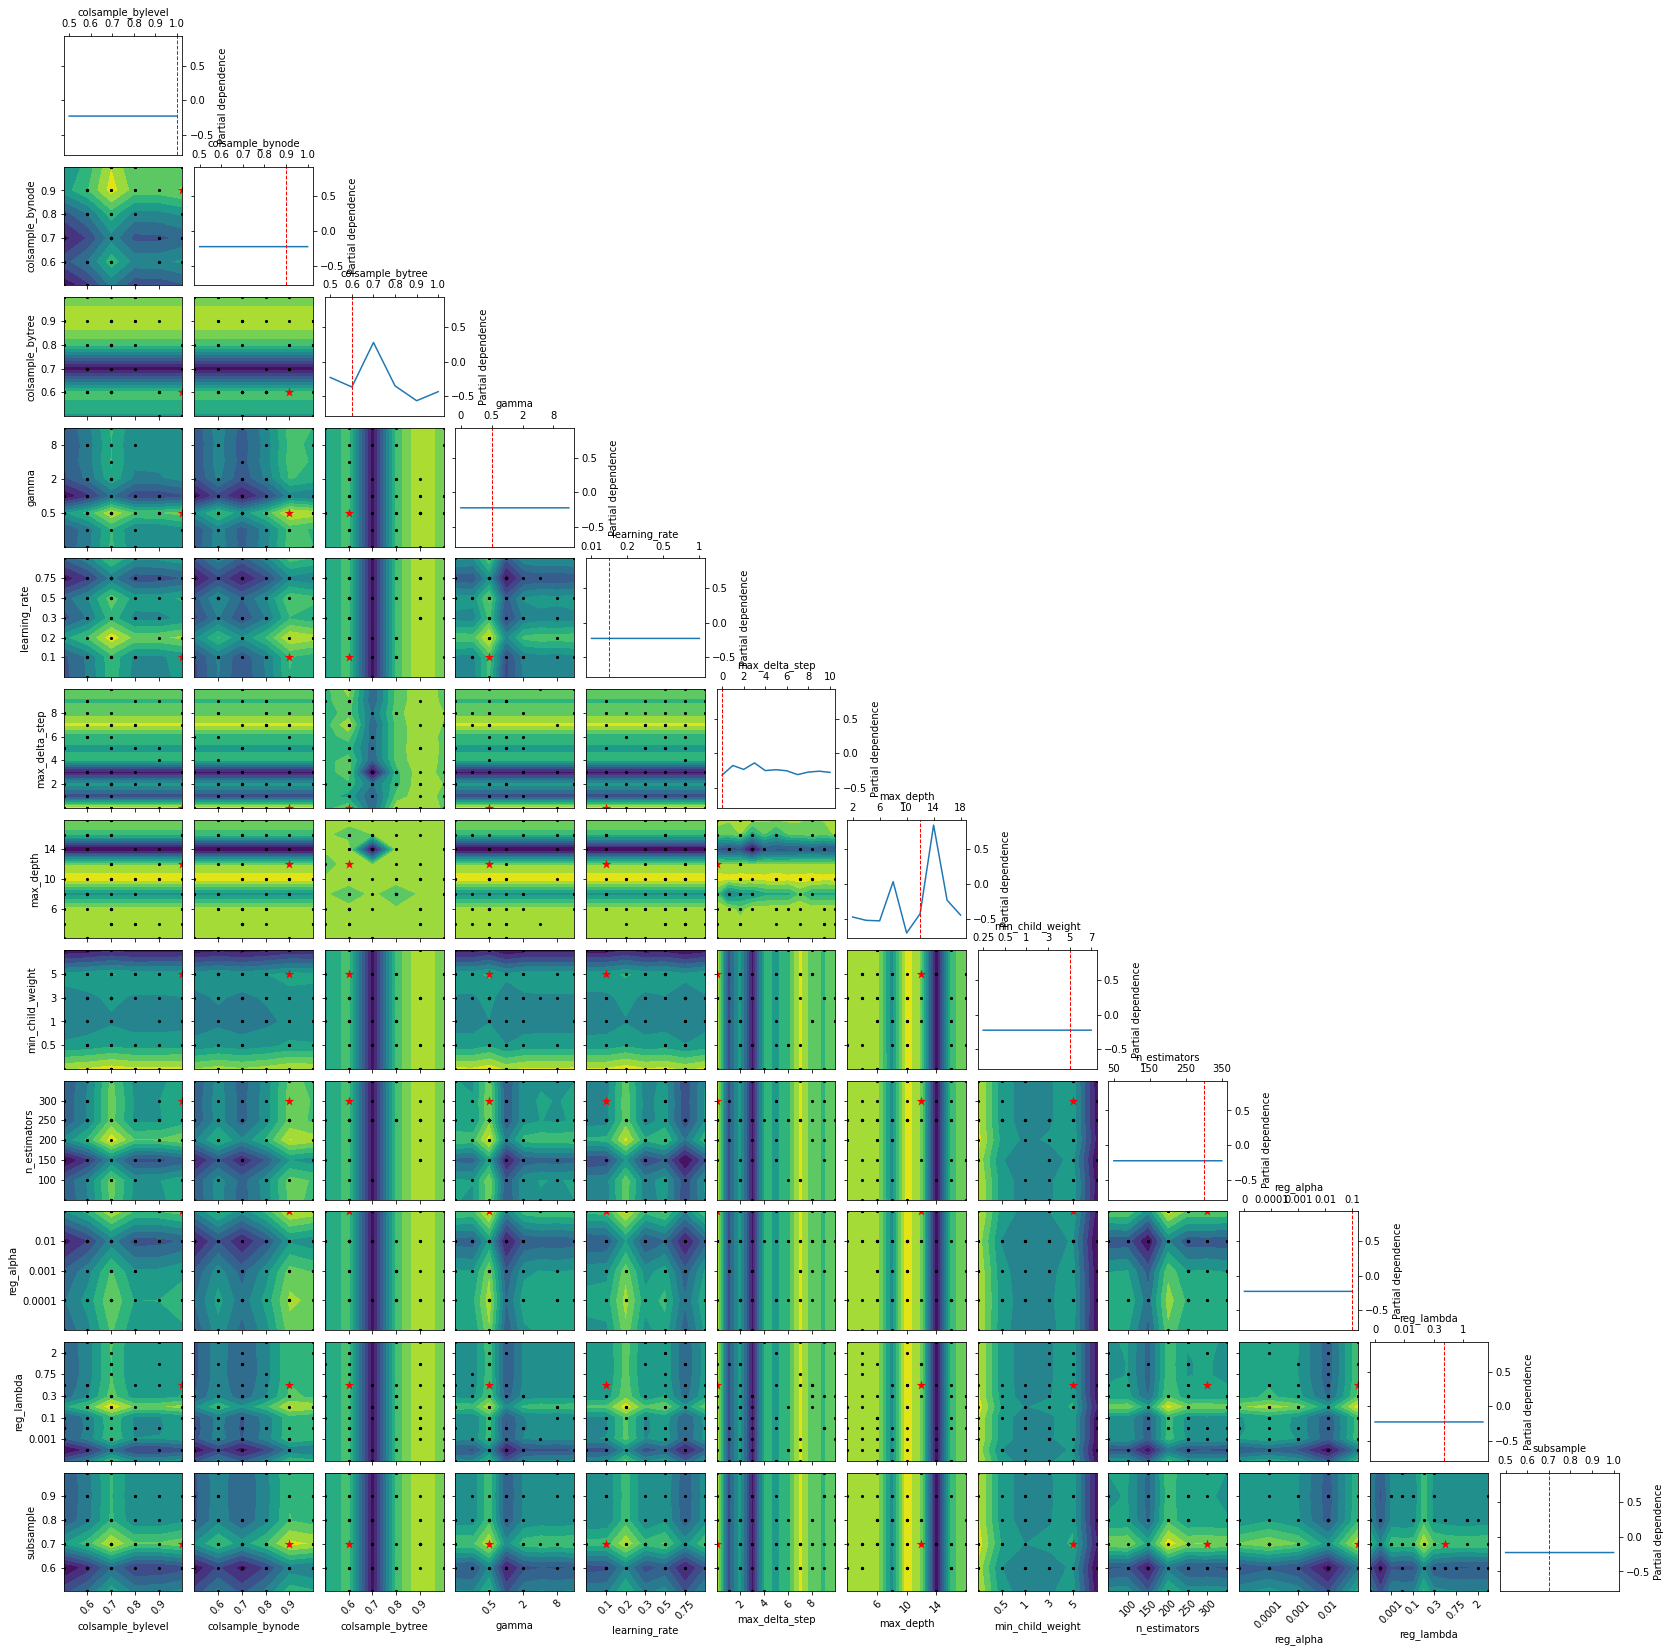

In [88]:
_ = plot_objective(cv_search.optimizer_results_[0])

In [89]:
best_estimator = cv_search.best_estimator_
best_estimator.save_model('./model.json')

In [90]:
model_name = f"{datetime.now().time()}_L{len(train_X)}".replace(":", ".")
location = f"models/xgboost/{model_name}"
location

'models/xgboost/02.11.36.475845_L4607592'

In [91]:
s3_conn = S3Connection()
bucket = s3_conn.bucket_name
with open('./model.json') as f:
    model = json.load(f)
    s3_conn.s3_client.put_object(Bucket=bucket, Key=location, Body=json.dumps(model))
os.remove("./model.json")

In [92]:
dump(cv_search, "./cv_search")
loaded = load('./cv_search')
s3_conn.s3_client.put_object(Bucket=bucket, Key=f"{location}CV_Search", Body=json.dumps(model))

{'ResponseMetadata': {'RequestId': 'HKQ15C8WQ6ZBPC8K',
  'HostId': 'ee8orYuydFvnxMlgJAkzvSnIGjBA9jupSxC9io9jTfBN1U1AMy9xqWW67qhkvUoeBf9gyWNVCGM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ee8orYuydFvnxMlgJAkzvSnIGjBA9jupSxC9io9jTfBN1U1AMy9xqWW67qhkvUoeBf9gyWNVCGM=',
   'x-amz-request-id': 'HKQ15C8WQ6ZBPC8K',
   'date': 'Mon, 25 Jul 2022 02:11:40 GMT',
   'x-amz-version-id': 'LOmajiQgXtlTmWOplLkN7JCLrp6B.jS4',
   'etag': '"1798f4b6d89bb74eae6a1efce3dcf461"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1798f4b6d89bb74eae6a1efce3dcf461"',
 'VersionId': 'LOmajiQgXtlTmWOplLkN7JCLrp6B.jS4'}

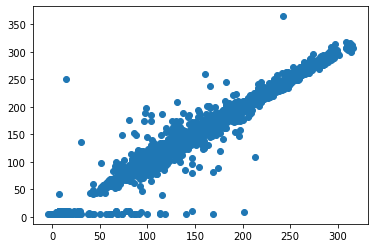

In [95]:
preds = best_estimator.predict(train_X)
plt.scatter(preds[:10000], train_y[:10000])

In [105]:
best_estimator.score(test_X, test_y)

0.9500382119620038

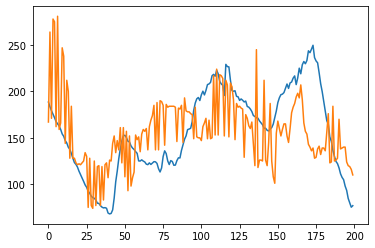

In [109]:
x_axis = [i for i in range(200)]
plt.plot(x_axis, preds[11800:12000])
plt.plot(x_axis, test_y[11800:12000])